# Picnic Health Biomedical Informatics Project
Author: Morgan Harrell

## Objective:
To explore the Massandopolis dataset and search for patterns that explain what is wrong with Massandopolis healthcare.
<br><br>
This notebook contains data exploration and visualization methods that characterize the data.
<br><br>
[Jump to conclusions](#conc)

In [219]:
import os
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

List of the available data

In [5]:
os.listdir('massandopolis/')

['medications.csv',
 'providers.csv',
 'imaging_studies.csv',
 'allergies.csv',
 'procedures.csv',
 'organizations.csv',
 'conditions.csv',
 'careplans.csv',
 'encounters.csv',
 'immunizations.csv',
 'patients.csv',
 'concepts.csv',
 'observations.csv']

## Describing the patient population
Is there anything unusual about our patient population that may point to healthcare anomalies?

In [7]:
patient_df = pd.read_csv('massandopolis/patients.csv')

In [9]:
patient_df.head(3)

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,MAIDEN,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,ADDRESS,CITY,STATE,ZIP
0,c0d528b6-cdae-4d98-8936-a270f8827eb7,2013-02-10,NaN,999-83-3170,NaN,NaN,NaN,Claudette391,Hahn503,NaN,NaN,NaN,white,french_canadian,F,Framingham Massandopolis US,239 Schaden Glen,Randolph,Massandopolis,2368.0
1,d709f84f-7d2c-440b-a979-2bc27d41f63a,1994-01-10,2019-01-07,999-31-7937,S99989196,X43239863X,Ms.,Christina143,Langworth352,NaN,NaN,NaN,black,dominican,F,Lynn Massandopolis US,535 Romaguera Annex Unit 82,Boston,Massandopolis,2108.0
2,92aa6efc-004f-4e01-b0be-9aafa40d9857,1989-08-27,NaN,999-59-2188,S99973592,X80581589X,Mrs.,Robbyn526,Eichmann909,NaN,Kohler843,M,hispanic,central_american,F,Salem Massandopolis US,986 Franecki Road Apt 37,Bellingham,Massandopolis,2019.0


In [130]:
#Convert dates from strings
patient_df['BIRTHDATE'] = pd.to_datetime(patient_df['BIRTHDATE'], infer_datetime_format=True)
patient_df['DEATHDATE'] = pd.to_datetime(patient_df['DEATHDATE'], infer_datetime_format=True)

In [249]:
#Check that each ID is unique
print(patient_df['Id'].nunique())
print(len(patient_df))

8360
8360


### What is the patient age distribution?

In [227]:
#Add column for patient age, either current or at date of death
def calc_age(row):
    end_date = pd.to_datetime('today').date()
    if not pd.isnull(row['DEATHDATE']):
        end_date = row['DEATHDATE'].date()
    return round((end_date - row['BIRTHDATE'].date()).days/365, 1)

In [228]:
patient_df['AGE'] = patient_df.apply(calc_age, axis=1)

Text(0.5, 1.0, 'Patient Age Histogram')

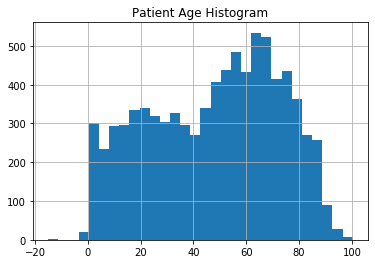

In [234]:
patient_df['AGE'].hist(bins=30)
plt.title('Patient Age Histogram')

In [231]:
#Some patient have a negative age. Must be errors
patient_df[patient_df['AGE'] < 0]

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,...,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,ADDRESS,CITY,STATE,ZIP,AGE
1092,f274e59b-681e-45fa-89f5-7ef6bd291b4c,2003-11-12,1988-11-27,999-10-3307,NaN,NaN,NaN,Shawn523,Koch169,NaN,...,NaN,white,irish,M,Springfield Massandopolis US,978 O'Connell Underpass Apt 25,Hanson,Massandopolis,2341.0,-15.0
5377,82186679-c053-4d63-b66e-fc082c59ea03,1971-07-17,1957-02-02,999-62-9908,NaN,NaN,NaN,Lashay246,Huel628,NaN,...,NaN,white,french,F,Cambridge Massandopolis US,109 Schiller Grove Suite 92,Milford,Massandopolis,1757.0,-14.5


### What are the patient race, ethnicity and gender proportions?

Text(0.5, 1.0, 'Race Proportion')

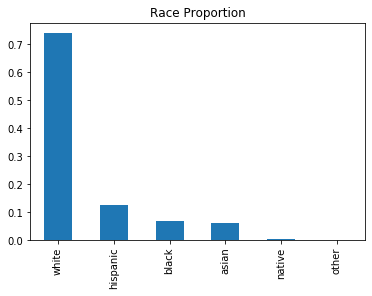

In [245]:
patient_df['RACE'].value_counts(normalize=True).plot.bar()
plt.title('Race Proportion')

Text(0.5, 1.0, 'Ethnicity Proportion')

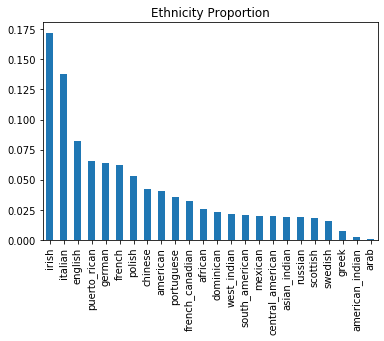

In [247]:
patient_df['ETHNICITY'].value_counts(normalize=True).plot.bar()
plt.title('Ethnicity Proportion')

Text(0.5, 1.0, 'Gender Proportion')

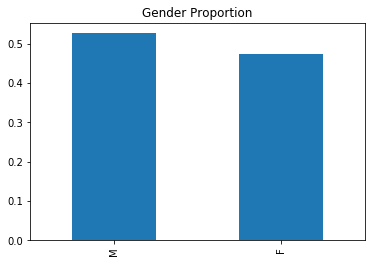

In [246]:
patient_df['GENDER'].value_counts(normalize=True).plot.bar()
plt.title('Gender Proportion')

#### Patient population conclusions:
There are 8360 patients. The population is majority white, Irish and Italian. Nothing super unusual yet..

## Patient Encounter Patterns
How frequently are patients having encounters, and what is the nature of the encounter?

In [250]:
enc_df = pd.read_csv('massandopolis/encounters.csv')

In [251]:
enc_df.head(3)

,Id,START,STOP,PATIENT,PROVIDER,ENCOUNTERCLASS,CODE,DESCRIPTION,COST,REASONCODE,REASONDESCRIPTION
0,1ef67c37-7306-4be4-9668-a93f34972544,2013-02-10T15:52:34Z,2013-02-10T16:07:34Z,c0d528b6-cdae-4d98-8936-a270f8827eb7,12c9daf5-a29c-36c9-ac55-28972463e566,wellness,185349003,Encounter for check up (procedure),129.16,NaN,NaN
1,158ced22-0023-4934-b046-451696f2d516,2013-03-17T15:52:34Z,2013-03-17T16:07:34Z,c0d528b6-cdae-4d98-8936-a270f8827eb7,12c9daf5-a29c-36c9-ac55-28972463e566,wellness,185349003,Encounter for check up (procedure),129.16,NaN,NaN
2,3980f194-389d-42f5-b477-f7c99598d6be,2013-05-19T15:52:34Z,2013-05-19T16:22:34Z,c0d528b6-cdae-4d98-8936-a270f8827eb7,12c9daf5-a29c-36c9-ac55-28972463e566,wellness,185349003,Encounter for check up (procedure),129.16,NaN,NaN


In [255]:
#Convert datetimes from strings
enc_df['START'] = pd.to_datetime(enc_df['START'], infer_datetime_format=True)
enc_df['STOP'] = pd.to_datetime(enc_df['STOP'], infer_datetime_format=True)

### Encounter Counts

Text(0.5, 1.0, 'Number of Encounter Counts')

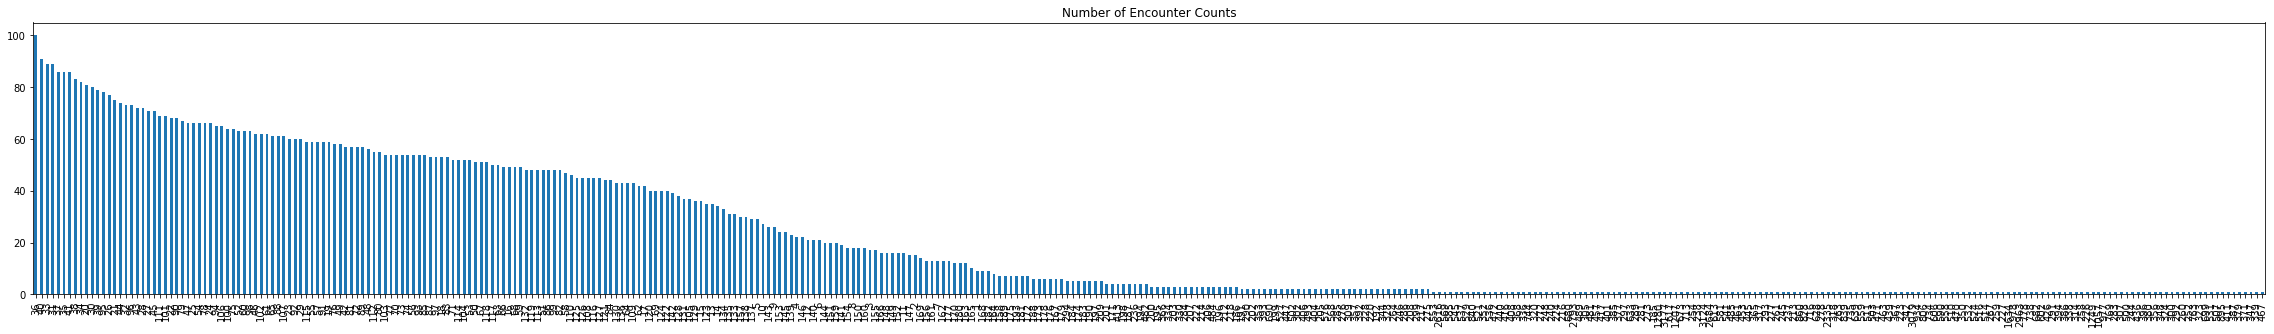

In [315]:
enc_df['PATIENT'].value_counts().value_counts().plot.bar(figsize=(40,5))
plt.title('Number of Encounter Counts')

Text(0.5, 1.0, 'Encounter Count Boxplot')

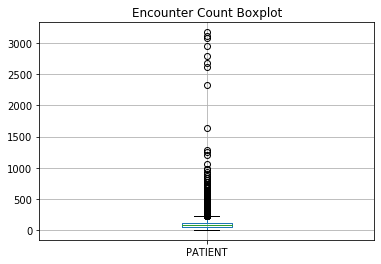

In [316]:
pd.DataFrame(enc_df['PATIENT'].value_counts()).boxplot()
plt.title('Encounter Count Boxplot')

In [314]:
enc_df['PATIENT'].value_counts().mean()

89.55011961722488

In [309]:
enc_df['PATIENT'].value_counts().median()

76.0

In [305]:
enc_df['PATIENT'].value_counts().max()

3177

There is high skew for number of encounters per patient. There is a group of patients with a very high number of encounters. One patient has 3177 encounters!

### Encounter Duration by Type

In [337]:
enc_df['DURATION_MIN'] = (enc_df['STOP'] - enc_df['START']).dt.seconds/60

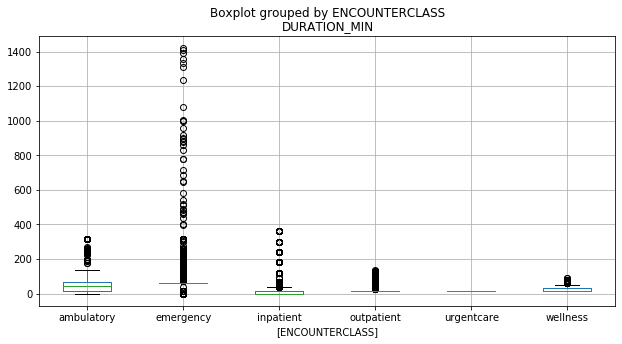

In [343]:
enc_df[['ENCOUNTERCLASS', 'DURATION_MIN']].boxplot(by='ENCOUNTERCLASS', figsize=(10,5))

Emergency encounters have required a much longer duration of care. We can further look into this, and if we find evidence that this is a large issuse, can train in emergency preparedness for Massandopolis healthcare workers. However, I don't believe this is the highest priority issue, and will look to other issues in the data.

### Encounter Cost

Text(0.5, 1.0, 'Cost by Encounter Class')

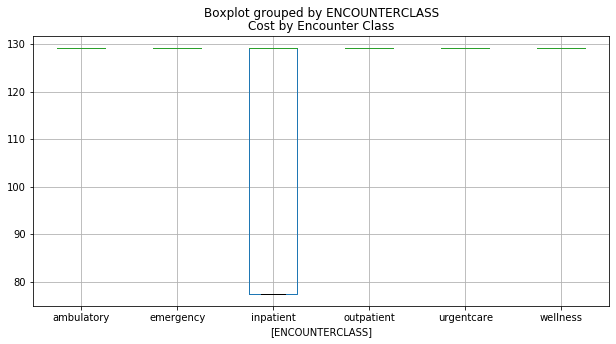

In [363]:
enc_df[['ENCOUNTERCLASS', 'COST']].boxplot(by='ENCOUNTERCLASS', figsize=(10,5))
plt.title('Cost by Encounter Class')

In [346]:
enc_df['COST'].value_counts()

129.16    736461
77.49      12178
Name: COST, dtype: int64

Text(0.5, 1.0, 'Cost by Encounter Duration in Minutes')

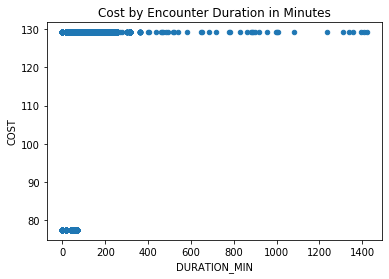

In [364]:
enc_df[['DURATION_MIN', 'COST']].plot(kind='scatter', x='DURATION_MIN', y='COST')
plt.title('Cost by Encounter Duration in Minutes')

Strangely, encounters cost either 129.16 or 77.49, regardless of their type or duration. Although this is nice for the payor, this is an issue when encounter durations that last for an extended period.

## Cost Patterns

### Procedure Costs by Year

In [365]:
procedure_df = pd.read_csv('massandopolis/procedures.csv')

In [366]:
procedure_df.head()

,DATE,PATIENT,ENCOUNTER,CODE,DESCRIPTION,COST,REASONCODE,REASONDESCRIPTION
0,2013-05-19,c0d528b6-cdae-4d98-8936-a270f8827eb7,3980f194-389d-42f5-b477-f7c99598d6be,428191000124101,Documentation of current medications,422.21,NaN,NaN
1,2013-07-21,c0d528b6-cdae-4d98-8936-a270f8827eb7,be7e1a8d-cbe3-4503-a058-6edbe7cafa48,428191000124101,Documentation of current medications,757.03,NaN,NaN
2,2013-12-07,c0d528b6-cdae-4d98-8936-a270f8827eb7,06429fa8-52a8-4e07-bd6a-b102b136cfa6,313191000,Injection of adrenaline,4445.27,NaN,NaN
3,2013-12-20,c0d528b6-cdae-4d98-8936-a270f8827eb7,4fa6e02b-272c-4469-8ef6-814ac1fab7ce,395142003,Allergy screening test,516.65,NaN,NaN
4,2014-07-20,c0d528b6-cdae-4d98-8936-a270f8827eb7,966d9bb4-f96f-411f-a17e-b474d4dd113b,428191000124101,Documentation of current medications,947.88,NaN,NaN


I can see within the first few rows of the procedure table that codes have varying costs. This may be a function of time. I will further investigate.

In [372]:
procedure_df['DATE'] = pd.to_datetime(procedure_df['DATE'], infer_datetime_format=True)

In [375]:
procedure_df['YEAR'] = procedure_df['DATE'].dt.year

In [682]:
tmp = procedure_df[['YEAR', 'DESCRIPTION', 'COST']].groupby(['YEAR', 'DESCRIPTION']).mean().unstack().reset_index()
tmp = tmp[tmp['YEAR'] > 1989].reset_index(drop=True)
tmp = tmp.dropna(axis= 1, thresh=12)

In [683]:
tmp.shape

(30, 127)

In [684]:
drop_list = []
for col in tmp.columns[tmp.std() < 100].values:
    level, name = col
    drop_list.append(name)
    
drop_list.remove('')
#drop_list

In [685]:
tmp = tmp.drop(drop_list, axis=1, level=1)

In [686]:
tmp.shape

(30, 66)

Text(0.5, 1.0, 'Procedure Average Cost by Year')

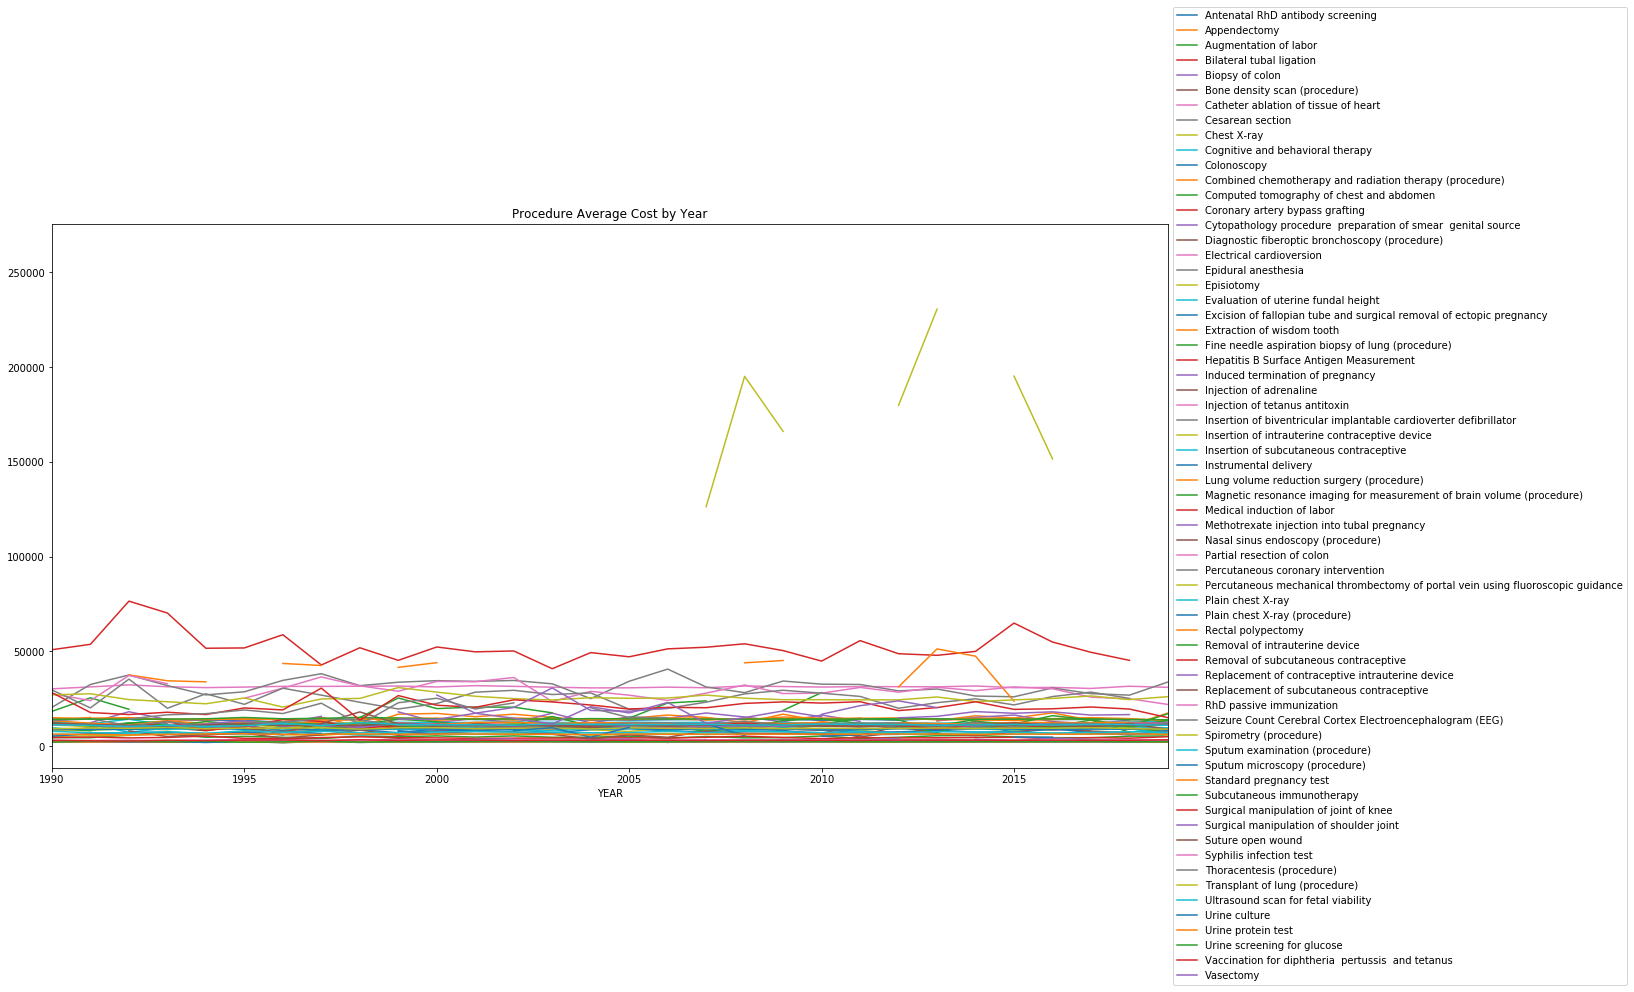

In [687]:
tmp.plot(x='YEAR', y='COST', figsize=(20,10))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Procedure Average Cost by Year')

There's variance but not a huge upward trend in cost over 20 years. Let's repeat the same for medications.

### Medication Costs by Year

In [672]:
med_df = pd.read_csv('massandopolis/medications.csv')

In [673]:
med_df.head()

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION,COST,DISPENSES,TOTALCOST,REASONCODE,REASONDESCRIPTION
0,2013-12-07,2013-12-07,c0d528b6-cdae-4d98-8936-a270f8827eb7,06429fa8-52a8-4e07-bd6a-b102b136cfa6,312617,predniSONE 5 MG Oral Tablet,10.84,1,10.84,NaN,NaN
1,2013-12-20,NaN,c0d528b6-cdae-4d98-8936-a270f8827eb7,4fa6e02b-272c-4469-8ef6-814ac1fab7ce,997488,Fexofenadine hydrochloride 30 MG Oral Tablet,25.72,65,1671.80,NaN,NaN
2,2013-12-20,NaN,c0d528b6-cdae-4d98-8936-a270f8827eb7,4fa6e02b-272c-4469-8ef6-814ac1fab7ce,1870230,NDA020800 0.3 ML Epinephrine 1 MG/ML Auto-Inje...,470.29,65,30568.85,NaN,NaN
3,2014-12-03,2014-12-17,c0d528b6-cdae-4d98-8936-a270f8827eb7,2a24757d-039d-41d3-9570-4fe170c8a282,313782,Acetaminophen 325 MG Oral Tablet,5.40,1,5.40,10509002.0,Acute bronchitis (disorder)
4,2015-02-17,NaN,c0d528b6-cdae-4d98-8936-a270f8827eb7,6a95d43e-d1e5-4ab3-9a92-82f287b64f5d,895994,120 ACTUAT Fluticasone propionate 0.044 MG/ACT...,36.63,51,1868.13,233678006.0,Childhood asthma


In [674]:
med_df['START'] = pd.to_datetime(med_df['START'], infer_datetime_format=True)

In [675]:
med_df['YEAR'] = med_df['START'].dt.year

In [676]:
tmp = med_df[['YEAR', 'DESCRIPTION', 'COST']].groupby(['YEAR', 'DESCRIPTION']).mean().unstack().reset_index()
tmp = tmp[tmp['YEAR'] > 1989].reset_index(drop=True)
tmp = tmp.dropna(axis= 1, thresh=12)

In [677]:
tmp.shape

(30, 106)

In [678]:
drop_list = []
for col in tmp.columns[tmp.std() < 20].values:
    level, name = col
    drop_list.append(name)
    
drop_list.remove('')
#drop_list

In [679]:
tmp = tmp.drop(drop_list, axis=1, level=1)

In [680]:
tmp.shape

(30, 35)

Text(0.5, 1.0, 'Med Average Cost by Year')

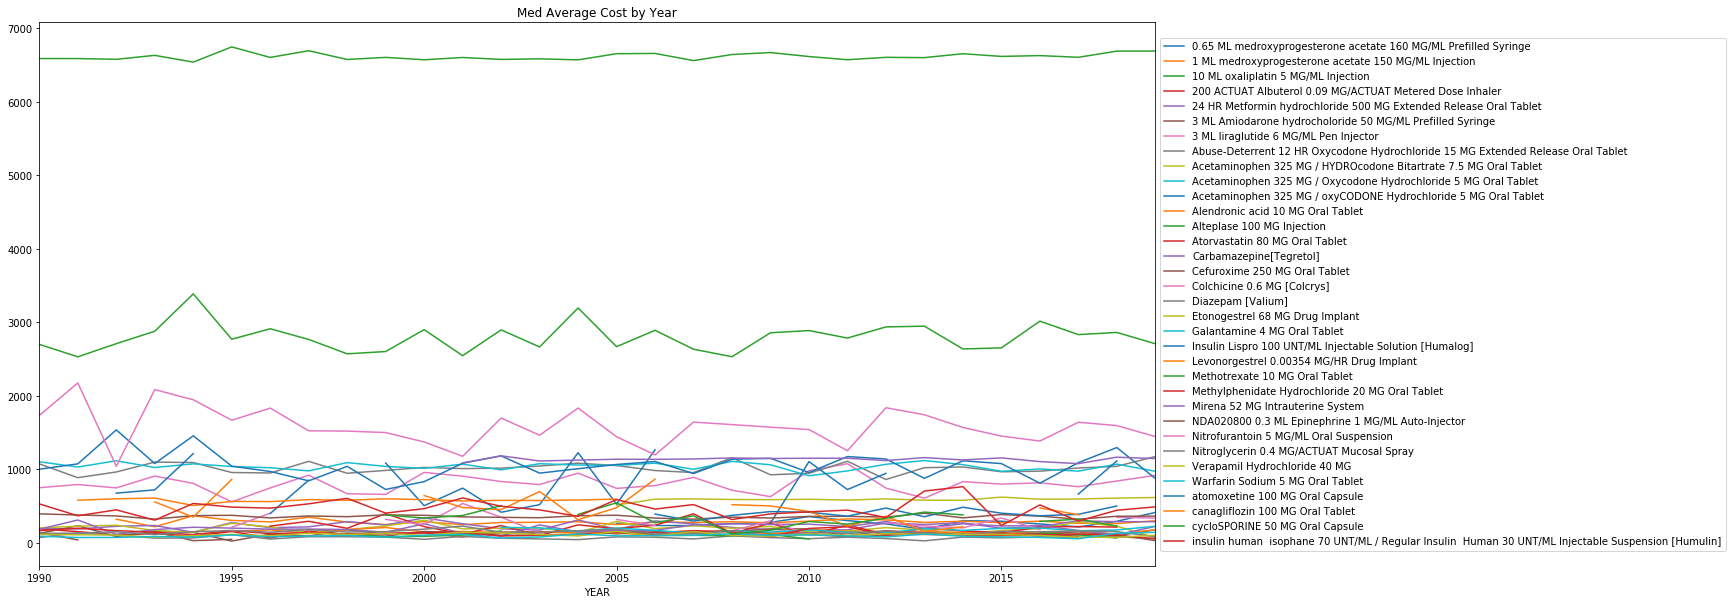

In [681]:
tmp.plot(x='YEAR', y='COST', figsize=(20,10))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Med Average Cost by Year')

Looks like average medication costs remain steady over the past 20 years.

<a id='conc'></a>
## Conclusions

I explored Massandopolis healthcare from their data in order to find anomalies that might answer "what is wrong with healthcare in Massandopolis?". 
<br><br>
I first characterized the patient population through age, race, and gender. I found that the underlying patient population appears fairly distributed among those three traits.
<br><br>
Next, I characterized patient encounter with type, time and cost. I found that the cost of encounters does not change with type or duration of encounter. Although it is very noble of Massandopolis healthcare workers to charge a flat rate, it is not commesurable with healthcare costs and likely causes strain on the healthcare system.
<br><br>
I further looked into cost to see trends in the average price of procedures and medications over the past 20 years. I found that prices have little variance over time. Again, that is nice to the payors, but not reflective of changes in practice and changes in supplies. Maybe part of what's wrong with healthcare in Massandopolis is that they are losing money and it is straining the healthcare system.
<br><br>
<br><br>
For further work, I've brainstormed a few other points to look in to. I could determine if there are treatment trends within patient stratifications. Maybe patients of different race are treated disparately, evidenced by different observations noted. There are several datasets I did not use. I can explore the allergies dataset, immunizations, etc. for outliers and anomalies. I could also explore the providers dataset and possibly model if providers practice similarly or disparately.
<br><br>
There may be something wrong with healthcare in Massandopolis, but I'm happy to see such a complete dataset to help diagnose their issues. There is a lot of work to be done & I'm happy to provide assistance.